In this jupyte file we will focus on preprocessing raw tweet into list of words and corresponding features

# Vocabulary building

Before preprocessing each raw data into training and furthre processing, we need to define our vocabulary. However our dataset's words are not easily separable by whitespaces only due to following reasons.
1. Seperators: Words can be sperated by multiple characters including whitespace for words, period for sentence ending, comma for clause endings, dash for connected words and : or ; to for beginning independent clauses. But note that last two characters can be used as emojis
2. Word contractions: word contractions can be viewed as complete new token, but in the end it is just combination of two words. Common word contractions are related to to be's and modal verbs.
3. Special words: Due to freedom of writing tweets, we can observe multiple emphasizes on words including hashtags, and repeated characters like (hey to heyyyy). These features should be taken special treatment but for vocabulary building these variations should be eliminated.
4. Stop words: The full list of stop words can be found in here https://kb.yoast.com/kb/list-stop-words/. But in our case, we are assuming pronouns like "the" can represent some meaningful information since it emphasizes following nouns.
5. Word variations: In english word can take multiple forms like plural form, verb tenses, incorrect spelling etc. Hence, simple word separation is not enough. And also in english, people use "'s" or "s'" to represent possessions
6. Numbers: we assumed that numbers usually conveys factual informations which is not helpful to identify person's opinion. And also we also have to treat numbers different from words. Thus in our case, we have completely removed every numbers.

Thus in order to overcome following problems, we created custom vocabulary building algorithm which follows following procedure.
1. First we are tokenizing the text using __white space, comma, period, new line__. We excluded : and ; since they are maybe part of emojis.
2. For each token we are looking for word contractions. In our case, we only considered hashtags, common contraction list to separate tokens which contains multiple words. And also, we have removed possessions from each tokens
3. In order to overcome word variation issue, first we have shrink consecutive repeated characters into 2 (fooooot -> foot). And then used their stems to build our vocabuary.

In [2]:
#Step number ZERO
#importing necessary libraries and declaring variables
import numpy as np
import pandas as pd
from nltk.stem import PorterStemmer
import wordninja
from string import digits
import re
remove_digits = str.maketrans('', '', digits)
ps = PorterStemmer()
#following list is found in github
contractions = { 
"ain't": "be not",
"aren't": "are not",
"can't": "can not",
"can't've": "can not have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}
p_samples = open('../twitter-datasets/train_neg.txt').readlines()
n_samples = open('../twitter-datasets/train_pos.txt').readlines()

In [27]:
#Step number ONE
#First layer of tokenizing
def vocabulary1(sentences):
    big_text=' '.join(sentences)
    #Tokenizing
    return re.split('[ .,\n]',big_text.lower().translate(remove_digits))
p_tokens1=vocabulary1(p_samples)
n_tokens1=vocabulary1(n_samples)

In [28]:
#Step number TWO
#Splitting tokens
def vocabulary2(tokens1):
    token_reps=[]
    #token filter
    i=0
    for token in tokens1:
        #check hashtags
        added=False
        if token.startswith("#"):
            splits=wordninja.split(token[1:])
            added=True
            token_reps+=splits
        #check abbreviations
        if token in contractions:
            splits=contractions[token].split(' ')
            added=True
            token_reps+=splits
        if not added:
            # removing possessions
            if (token.endswith("'s") | token.endswith("s'")):
                token_reps.append(token[:-2])
            else:
                token_reps.append(token)
    return token_reps
p_tokens2=vocabulary2(p_tokens1)
n_tokens2=vocabulary2(n_tokens1)

In [29]:
#Step number THREE
#Stemming tokens
def token_stemmer(token):
    #filtering multiple chars
    matches=re.findall(r'((\w)\2{2,})', token)
    for match in matches:
        token=token.replace(match[0],match[1]*2)
    #stemming
    return ps.stem(token)
def vocabulary3(tokens):
    return [token_stemmer(token) for token in tokens]
p_tokens3=vocabulary3(p_tokens2)
n_tokens3=vocabulary3(n_tokens2)

### Now let's analyze our filters

In [31]:
#Now let's analyze the data
import matplotlib.pyplot as plt
#total length of words
print([len(p_tokens1)+len(n_tokens1),
       len(p_tokens2)+len(n_tokens2),
       len(p_tokens3)+len(n_tokens3),])

[3615302, 3692848, 3692848]


As expected after the second step the number of individual tokens increased by almost 80k.

In [34]:
voc1=set(p_tokens1).union(set(n_tokens1))
voc2=set(p_tokens2).union(set(n_tokens2))
voc3=set(p_tokens3).union(set(n_tokens3))
print(len(voc1),len(voc2),len(voc3))

102368 86176 68056


But the total unique words in each steps decreased significantly. And we have successfully generalized almost 32K unique words, which is equal to 32% of just separating by spaces. Now let's look at the distribution of each words

In [35]:
p_voc1=pd.Series(p_tokens1).value_counts()
n_voc1=pd.Series(n_tokens1).value_counts()
p_voc2=pd.Series(p_tokens2).value_counts()
n_voc2=pd.Series(n_tokens2).value_counts()
p_voc3=pd.Series(p_tokens3).value_counts()
n_voc3=pd.Series(n_tokens3).value_counts()

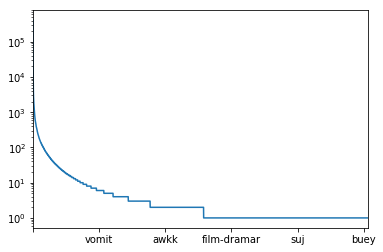

In [36]:
p_voc3.plot(logy=True)
plt.show()

In [43]:
[np.sum([p_voc3==1])/len(p_voc3),np.sum([p_voc3==1])/len(p_tokens3)]

[0.49071476549843929, 0.012286194786565761]

The graph above shows distribution of our last vocabulary's number of occurences. As expected, it shows similar relationship as Zipf's law, but note that number of words which has only 1 occurence in entire text. Almost 50% of the vocabulary takes only 1.2% of the text, which implies it's not worth keeping the 50 percent of the words for simplicity.

Now in addition it is useful to add tf-idf feature for our vocabulary for efficiency. :)

In [60]:
# term frequencies
vocabulary=pd.concat([p_voc3.rename("p")/p_voc3.sum(), n_voc3.rename("n")/n_voc3.sum()], axis=1).fillna(0)
# caluclating idfs
idf=np.array([1.301 if val==0 else 1 for val in vocabulary.p*vocabulary.n])
vocabulary.p=vocabulary.p*idf
vocabulary.n=vocabulary.n*idf
vocabulary

,p,n
,2.029030e-01,1.632040e-01
,6.435178e-07,0.000000e+00
,6.435178e-07,0.000000e+00
!,1.492951e-02,3.164950e-02
"""",5.658110e-03,5.396290e-03
$,2.408864e-04,2.333725e-04
%,1.820250e-04,9.095544e-05
&,1.798981e-03,2.490504e-03
',1.405748e-03,2.059662e-03
(,2.190879e-02,1.683274e-03


# Feature Pre-Processing
Since we have built vocabulary, now let's write feature pre-processing function which converts given tweet into corresponding vocabulary indices and additional features. As we've mentioned earlier in each tweets there can be multiple characteristics that we should consider. These are __is word is hashtagged?, what is Parts Of Speech tag?, is this word negation?, how emphasized give word is?__.

Our solution to this problems is following:
1. 1st step of vocabulary calculation to find tokens
2. 2nd step of vocabulary calculation, but in addition we have to keep track of given token is hashtagged or not
3. Before stemming we should find parts of speech tag for each words and negations
4. 3rd step of vocabulary calculation, but also we are keeping track of number of consecutive characters

In [98]:
#Pre processing steps 
from nltk import pos_tag
negates=["not","none","no","nobody","nothing","neither","nowhere","never"]

def token_stemmer(token):
    #filtering multiple chars
    matches=re.findall(r'((\w)\2{2,})', token)
    total=0
    for match in matches:
        total+=len(match[0])
        token=token.replace(match[0],match[1]*2)
    #stemming
    return [ps.stem(token),total]

def pre_processing(sentence):
    #1st step
    tokens=re.split('[ .,\/\\\]*',sentence.lower().translate(remove_digits))
    tokens2=[]
    #2nd step
    ishashtagged=[]
    for token in tokens:
        if(token==''):
            continue
        #check hashtags
        added=False
        if token.startswith("#"):
            splits=wordninja.split(token[1:])
            tokens2+=splits
            ishashtagged+=[1]*len(splits)
            added=True
        #check abbreviations
        if token in contractions:
            splits=contractions[token].split(' ')
            tokens2+=splits
            ishashtagged+=[0]*len(splits)
            added=True
        if not added:
            tokens2.append(token)
            ishashtagged.append(0)
    #3rd step
    pos_tags=np.array([pos_tag[1] for pos_tag in pos_tag(tokens2)])
    negations=np.array([token in negates for token in tokens2])
    #4th step
    words_emphasizes=np.array([token_stemmer(token) for token in tokens2])
    #Returning the result
    return [words_emphasizes[:,0],ishashtagged,pos_tags,negations,words_emphasizes[:,1]]

Since we have written it, let's look at it's speed

In [99]:
#Testing
print(pre_processing("I don't like my #machinelearning teachers, but I looooove them 123345. :)"))
import timeit
def wrapper():
    pre_processing("I don't like my #machinelearning teachers, but I looooove them 123345. I don't like my #machinelearning teachers, but I loooove them 123345. :) I don't like my #machinelearning teachers, but I looove them 123345. :|")
timeit.timeit(wrapper,number=100)

C:\Users\Bilguun\Anaconda3\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


[array(['i', 'do', 'not', 'like', 'my', 'machin', 'learn', 'teacher', 'but',
       'i', 'loov', 'them', ':)'],
      dtype='<U7'), [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], array(['NNS', 'VBP', 'RB', 'IN', 'PRP$', 'NN', 'VBG', 'NNS', 'CC', 'JJ',
       'VBP', 'PRP', 'VB'],
      dtype='<U4'), array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False], dtype=bool), array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '5', '0', '0'],
      dtype='<U7')]


0.993959108724539

For 200K tweet, it will take approximately 40 minutes in my computer. Thus let's calculate it and save it into a file

In [104]:
import pickle
p_processed=[pre_processing(tweet) for tweet in p_samples]
pickle.dump(p_processed, open('../prepared-data/p_processed', 'wb'))
print("Finished Half")
n_processed=[pre_processing(tweet) for tweet in n_samples]
pickle.dump(n_processed, open('../prepared-data/n_processed', 'wb'))
pickle.dump(vocabulary, open('../prepared-data/vocabulary', 'wb'))

C:\Users\Bilguun\Anaconda3\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Finished Half


In [105]:
pickle.load(open('../prepared-data/n_processed', 'rb'))

[[array(['<user>', 'i', 'dunno', 'justin', 'read', 'my', 'mention', 'or',
         'not', 'onli', 'justin', 'and', 'god', 'know', 'about', 'that',
         'but', 'i', 'hope', 'you', 'will', 'follow', 'me', 'believ', '\n'],
        dtype='<U7'),
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
  array(['NN', 'NN', 'VBP', 'NN', 'VB', 'PRP$', 'NN', 'CC', 'RB', 'RB', 'NN',
         'CC', 'NN', 'VBZ', 'IN', 'DT', 'CC', 'VBP', 'VBP', 'PRP', 'MD',
         'VB', 'PRP', 'VB', 'NN'],
        dtype='<U4'),
  array([False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False], dtype=bool),
  array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
         '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
        dtype='<U7')],
 [array(['becaus', 'your', 'logic', 'is', 'so', 'dumb', 'i', 'will', 'not',
        